In [1]:
import numpy as np 
import os
from tqdm.auto import tqdm
from PIL import Image
import torch

In [5]:
highest_positions = []
for idx in tqdm(range(2000)):
    sh_coeff = np.load(f"../../datasets/face/face2000_single_viz/ball_front_fullscale/{idx:05d}.npy")
    sh_gray = 0.299*sh_coeff[..., 0]  + 0.587*sh_coeff[..., 1] + 0.114*sh_coeff[..., 2]
    highest_position = np.unravel_index(np.argmax(sh_gray), sh_gray.shape)
    highest_positions.append(highest_position)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
# calculate distance from the most buttom 
highest_positions = np.array(highest_positions)
distance_from_bottom = highest_positions.copy()
distance_from_bottom[:, 0] = 127.5  - distance_from_bottom[:, 0]
distance_from_bottom[:, 1] = 255 - distance_from_bottom[:, 1]
distance_from_bottom = np.linalg.norm(distance_from_bottom, axis=1)


In [7]:
sorted_indices = distance_from_bottom.argsort()

In [8]:
def create_image_grid(images):
  """Creates an image grid of size 4x4 from a list of 16 PIL.Images.

  Args:
      images: A list of 16 PIL.Image objects.

  Returns:
      A new PIL.Image object containing the image grid.
  """
  if len(images) != 16:
    raise ValueError("List must contain exactly 16 images.")

  # Find the maximum width and height of the images
  max_width = max(image.size[0] for image in images)
  max_height = max(image.size[1] for image in images)

  # Calculate the total width and height of the grid
  grid_width = 4 * max_width
  grid_height = 4 * max_height

  # Create a new image for the grid
  grid_image = Image.new('RGB', size=(grid_width, grid_height))

  # Paste each image into the grid with padding
  for i, image in enumerate(images):
    row = i // 4
    col = i % 4
    x_offset = col * max_width
    y_offset = row * max_height

    # Paste the image with padding to center it within its grid cell
    paste_box = (x_offset + (max_width - image.size[0]) // 2,
                 y_offset + (max_height - image.size[1]) // 2,
                 x_offset + max_width,
                 y_offset + max_height)
    grid_image.paste(image, box=paste_box)

  return grid_image

In [9]:
image_out = []
for idx in sorted_indices[:16]:
    subdir = idx // 1000 * 1000
    img = Image.open(f"../../datasets/face/face2000_single/images/{subdir:05d}/{idx:05d}.png")
    gt_img = img.resize((256,256))
    sh_coeff = np.load(f"../../datasets/face/face2000_single_viz/ball_front_fullscale/{idx:05d}.npy")
    sh_coeff = np.clip(sh_coeff / np.percentile(sh_coeff,99.9), 0, 1)
    pos = highest_positions[idx]
    WIDTH = 5
    left = int(np.clip(pos[1] - WIDTH, 0, np.inf))
    right = int(np.clip(pos[1] + WIDTH, 0, np.inf))
    top = int(np.clip(pos[0] - WIDTH, 0, np.inf))
    bottom = int(np.clip(pos[0] + WIDTH, 0, np.inf))
    sh_coeff[top:bottom, left:right, 0] = 1
    sh_coeff[top:bottom, left:right, 1] = 0
    sh_coeff[top:bottom, left:right, 2] = 0
    sh_coeff = (sh_coeff * 255).astype(np.uint8)
    sh_coeff = Image.fromarray(sh_coeff)
    #sh_coeff = Image.open(f"../../datasets/face/face2000_single_viz/ball_bright_dark_back/{subdir:05d}/{idx:05d}.png")
    sh_coeff = sh_coeff.resize((256,256))
    img = Image.new("RGB", (512, 256))
    img.paste(sh_coeff, (0,0))
    img.paste(gt_img, (256,0))
    #print(highest_positions[idx])
    image_out.append(img)

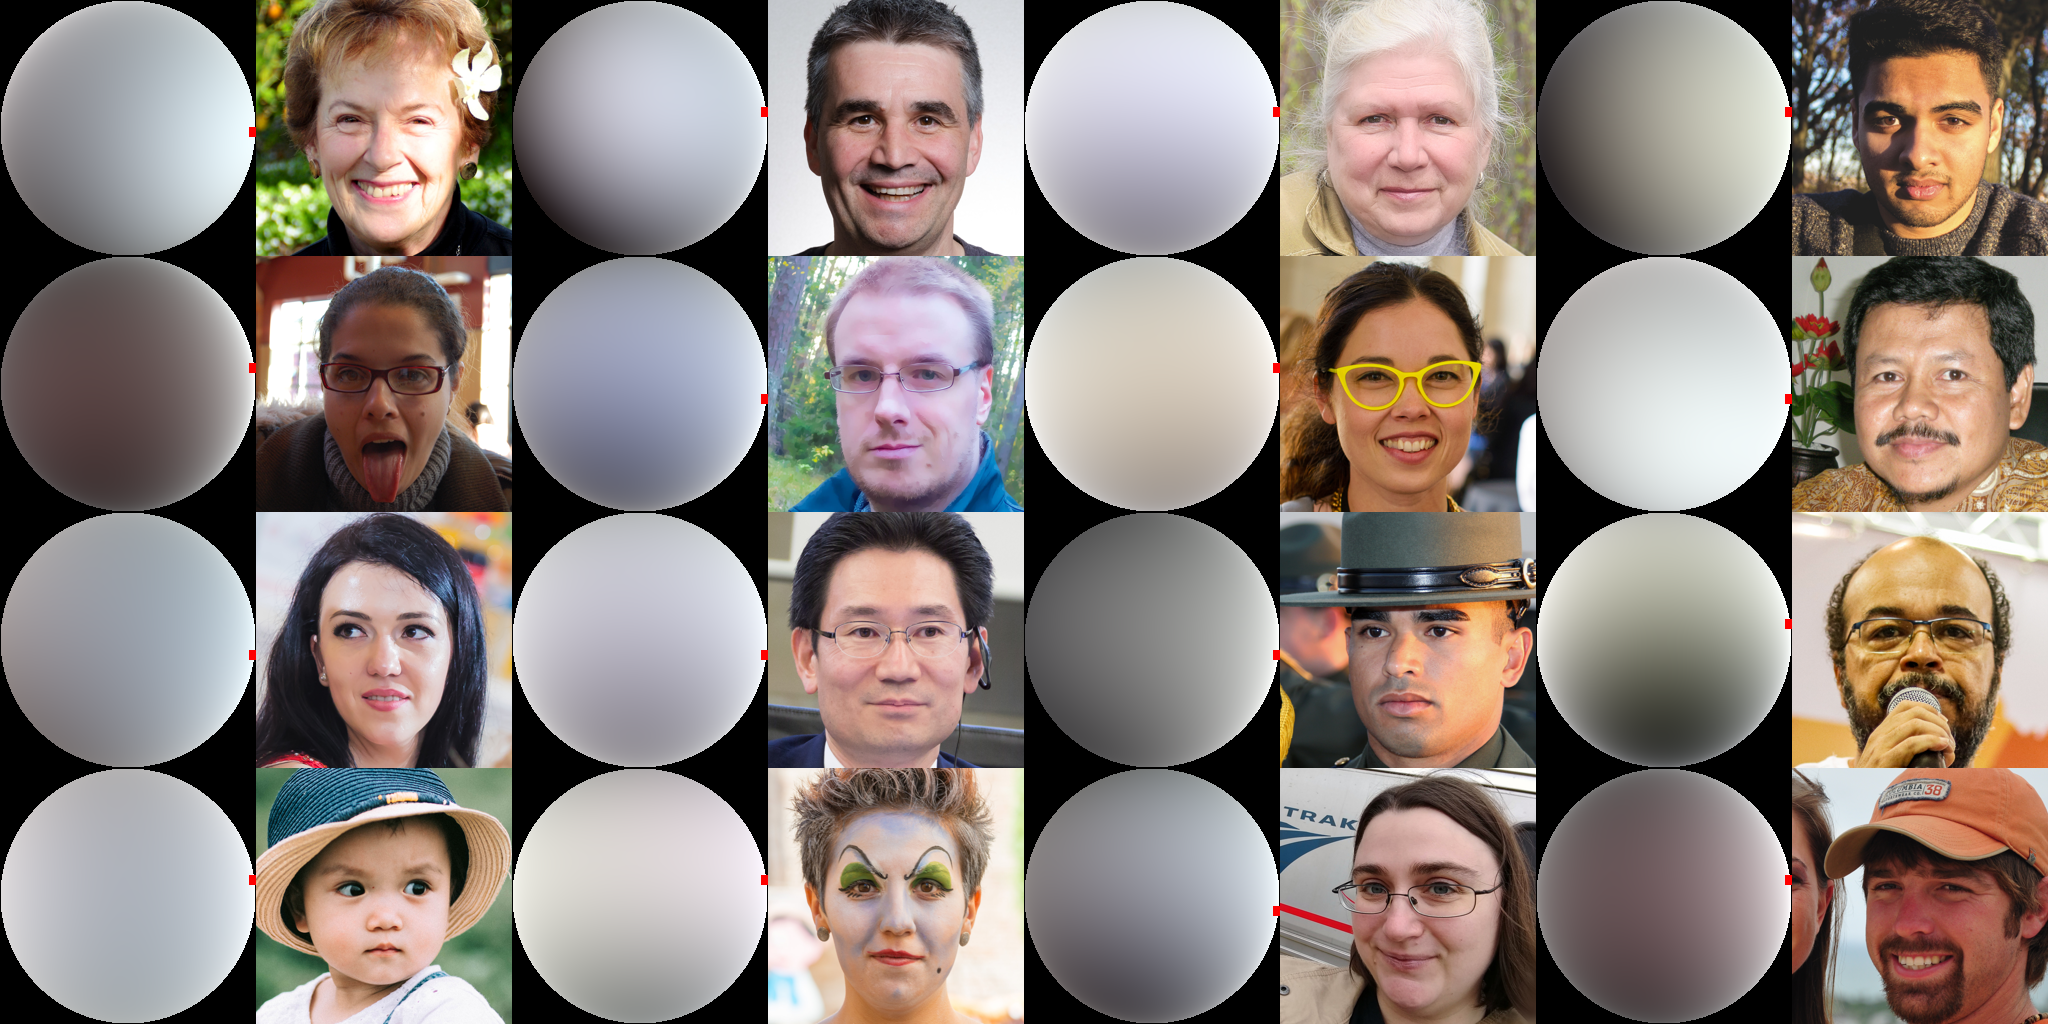

In [10]:
image_gird = create_image_grid(image_out)
display(image_gird)

In [ ]:
sorted_indices